In [1]:
!python -m pip install spiceypy > /dev/null 2>&1
!python -m pip install astroquery > /dev/null 2>&1

In [2]:
from astroquery.jplhorizons import Horizons
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime, timedelta

The James Webb Space Telescope (JWST) reached its final orbit on **January 24, 2022**, according to [this source](https://www.adn40.mx/ciencia/james-webb-orbita-final-gm-especial).


In [3]:
n = 2 # Number of bodies
cuerpos = np.array([None]*n)
tablas = np.array([None]*n)
nombre_cuerpos = ["-170","3"]

for i in range(0,n):
  cuerpos[i] = Horizons(id=nombre_cuerpos[i],location="@0",epochs={"start":"2022-01-24","stop":"2024-01-24","step":"1d"})
  tablas[i] = cuerpos[i].vectors()

The canonical units of the CRTBP:

For this system, the canonical units are defined as:

$$U_M = M = M_{\odot} + M_{\text{Earth}} = 1.989 \times 10^{30}\ \text{kg} + 5.972 \times 10^{24}\ \text{kg}$$

$$U_L = a = 1.496 \times 10^{11}\ \text{m}$$

$$U_T = \sqrt{\frac{U_L^3}{U_M G}}$$

$$U_V = \frac{U_L}{U_T}$$

$$\alpha = \mu_2 = \frac{M_{\text{Earth}}}{M}$$


In [4]:
G = 6.67e-11   #N²m²/kg
m1 = 1.989e30  #kg
m2 = 5.972e24  #kg
M =  m1 + m2   #kg
a = 1.496e11   #m
UL = a         #m
UM = M         #kg
UT = np.sqrt(UL**3/(UM*G)) #s
UV = UL/UT      #m/s
alpha = m2/M

In [5]:
# Create arrays to store the X, Y, Z positions of the bodies
X, Y, Z = np.array([None]*n), np.array([None]*n), np.array([None]*n)

# Create arrays to store the X, Y, Z velocity components of the bodies
VX, VY, VZ = np.array([None]*n), np.array([None]*n), np.array([None]*n)

for i in range(len(tablas)):
    X[i] = tablas[i]["x"].to("m").value / UL
    Y[i] = tablas[i]["y"].to("m").value / UL
    Z[i] = tablas[i]["z"].to("m").value / UL

    VX[i] = tablas[i]["vx"].to("m/s").value / UV
    VY[i] = tablas[i]["vy"].to("m/s").value / UV
    VZ[i] = tablas[i]["vz"].to("m/s").value / UV

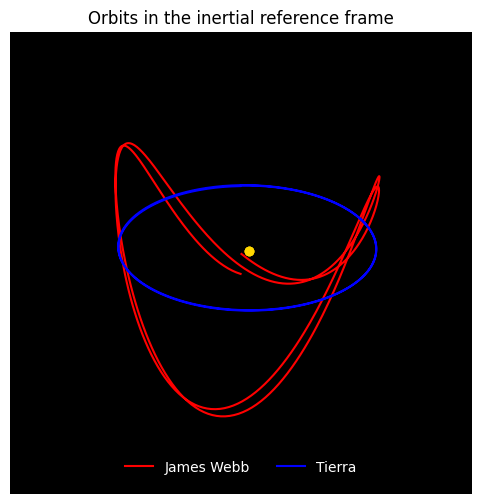

In [7]:
# We proceed to graph
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.plot3D(X[0],Y[0],Z[0],color="red",label='James Webb')
ax.plot3D(X[1],Y[1],Z[1],color="blue",label='Tierra')
T = np.zeros(3)
ax.plot3D(T,T,T,"o",color="gold")

plt.title("Orbits in the inertial reference frame",color="black")
leg = plt.legend(loc='upper center',bbox_to_anchor=(0.5,0.1),ncol=2,
           facecolor="black",frameon=False)
for text in leg.get_texts():
  text.set_color("white")
ax.set_facecolor('black')

plt.axis("off")
plt.show()

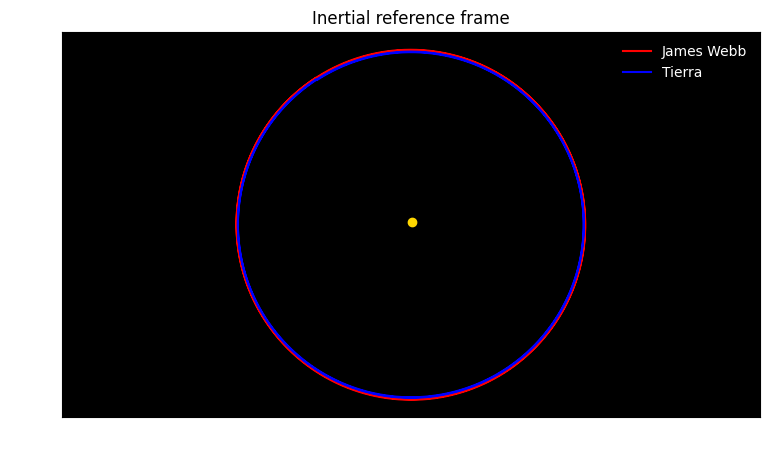

In [8]:
plt.figure(figsize=(9,5))
plt.rcParams['axes.facecolor'] = 'black'
plt.title("Inertial reference frame")

plt.plot(0,0,"o",color="gold")
plt.plot(X[0],Y[0],color="red",label='James Webb')
plt.plot(X[1],Y[1],color="blue",label='Tierra')

leg = plt.legend(loc=1,facecolor="black",frameon=False)
for text in leg.get_texts():
  text.set_color("white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.axis("equal")
plt.show()

## Angular velocity:

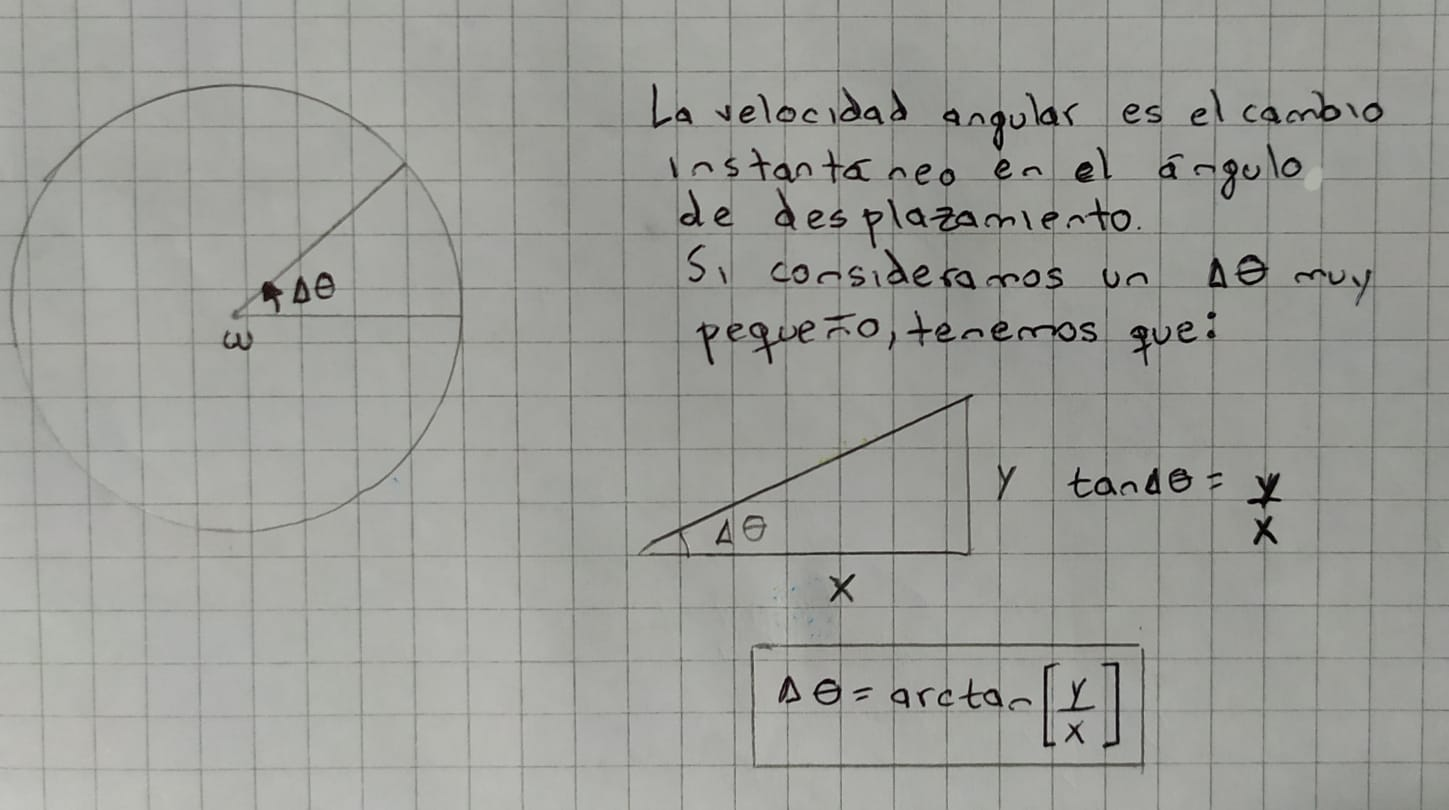

The instantaneous angular velocity of the Earth is given by:

$$\omega = \tan^{-1}\left(\frac{y}{x}\right)$$  

where $x$ and $y$ are the Earth's coordinates.

In [9]:
omega = np.array([None]*len(VX[1]))

for i in range(len(omega)):
  omega[i] = np.arctan2(Y[1][i],X[1][i]) # arct2 to give us the correct quadrant

The components of the position and velocity vectors of the particle can be converted to the rotating coordinate system by applying a rotation matrix at an angle equal to the rotation of the axes at time $t$, that is, $\theta = \omega = \tan^{-1}\left(\frac{y}{x}\right)$:

\begin{equation}
\begin{bmatrix}
\cos\omega & \sin\omega & 0\\
-\sin\omega & \cos\omega & 0\\
0 & 0 & 1
\end{bmatrix}
\end{equation}
  

In [10]:
# Here we will store the positions in the rotating reference frame
from numpy import zeros_like
rs_ine = np.array([None]*len(X[0]))
for i in range(len(X[0])):
  rs_ine[i] = [X[0][i],Y[0][i],Z[0][i]]
rs_rot = zeros_like(rs_ine)


# Here we perform the coordinate transformations (rotations)
Nt = len(rs_rot)
ts = np.linspace(0,len(X[0]),Nt)
for i in range(Nt):
    # Rotation matrix
    from spiceypy import rotate
    R = rotate(omega[i],3)

    # Apply rotation to the position vector
    from spiceypy import mxv
    rs_rot[i] = mxv(R,rs_ine[i])

In [11]:
vs_rot_num = zeros_like(rs_rot)
for i in range(1,Nt):
  vs_rot_num[i] = (rs_rot[i]-rs_rot[i-1])/(ts[i]-ts[i-1])
vs_rot_num[0] = np.array([0,0,0])

In [12]:
X_rot,Y_rot,Z_rot = np.array([None]*len(rs_rot)),np.array([None]*len(rs_rot)),np.array([None]*len(rs_rot))
for i in range(len(rs_rot)):
  X_rot[i] = rs_rot[i][0]
  Y_rot[i] = rs_rot[i][1]
  Z_rot[i] = rs_rot[i][2]

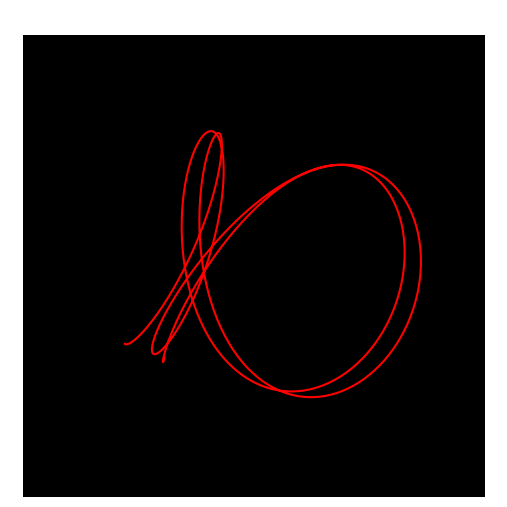

In [13]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.plot3D(X_rot,Y_rot,Z_rot,color="red")
plt.title("Órbita del James Webb en el sistema de referencia rotante",color="white")
for text in leg.get_texts():
  text.set_color("white")

ax.set_facecolor('black')
plt.axis("off")
plt.show()

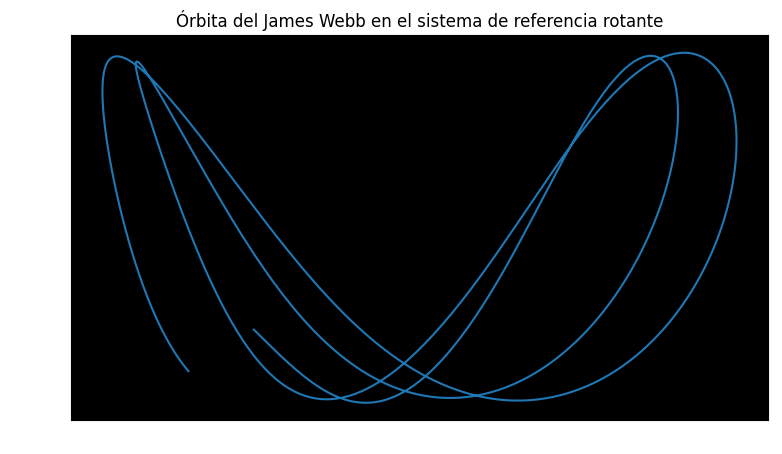

In [14]:
plt.figure(figsize=(9,5))
plt.title("Órbita del James Webb en el sistema de referencia rotante")
plt.plot(X_rot,Y_rot)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()

###Jacobi Constant

The value of the Jacobi constant is given by the following expression:

$$
\frac{2(1-\alpha)}{r_1} + \frac{2\alpha}{r_2} + (x^2 + y^2) - v^2 = C_J
$$


In [15]:
r1 = np.array([None]*len(X[0]))
r2 = np.array([None]*len(X[0]))
CJ = np.array([None]*len(X[0]))
for i in range(len(r1)):
  r1[i] = ((X_rot[i]+alpha)**2+(Y_rot[i]**2+Z_rot[i]**2))**0.5
  r2[i] = ((X_rot[i]+alpha-1)**2+(Y_rot[i]**2+Z_rot[i]**2))**0.5
  CJ[i] = (2*(1-alpha)/r1[i])+(2*alpha/r2[i])+(X_rot[i]**2+Y_rot[i]**2)-(np.linalg.norm(vs_rot_num[i]))**2

In [16]:
t = np.linspace(0,len(X[1])-1,len(X[1]))
t1 = np.zeros((8))
for i in range(8):
  t1[0] = 0
  t1[i] = t1[i-1]+100

In [17]:
# Create an array to store the dates
fechas = np.array([None]*8)

# Date format: Year, Month, Day, Hour, Minutes, Seconds, Milliseconds
start_date = datetime(2022, 1, 24)

for i in range(8):
  fechas[i] = start_date
  start_date = start_date + timedelta(days=100)  # timedelta = "step" size between the dates
  fechas[i] = fechas[i].strftime('%Y %b %d')  # Format to print the month name instead of the number

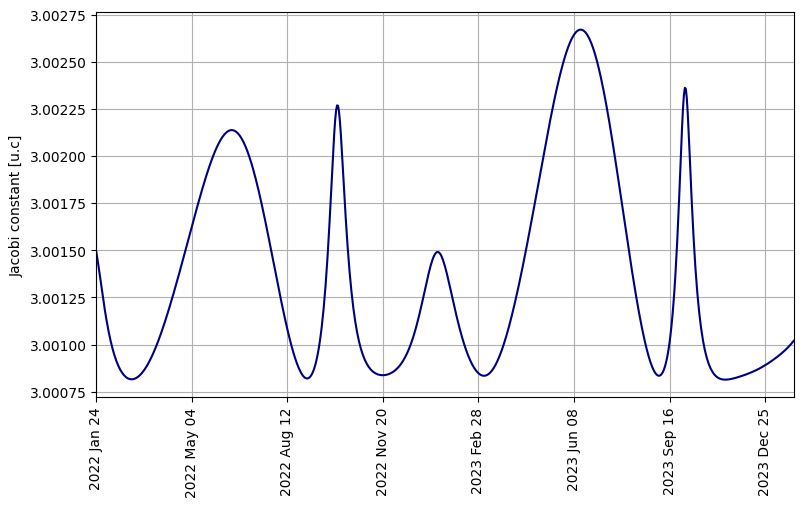

In [18]:
plt.figure(figsize=(9,5))
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(t,CJ,color="navy")
plt.xticks(t1, fechas, rotation ='vertical')
plt.xlim(min(t),max(t))
plt.ylabel("Jacobi constant [u.c]")
plt.grid()
plt.show()

In [19]:
print("The largest difference in the values of the Jacobi constant is", max(CJ) - min(CJ), "[u.c]")
print("On average, the value of the Jacobi constant is", np.mean(CJ), "[u.c]")

The largest difference in the values of the Jacobi constant is 0.001857083705981477 [u.c]
On average, the value of the Jacobi constant is 3.0013619660479454 [u.c]


It is evident that the Jacobi constant $C_J$ remains approximately constant, with a value of $C_J \approx 3$.